#### Adamantios Zaras AM: 06
#### Panagiotis Souranis AM: 17

# Description
In this part of the project we used 3 different resampling techniques in order to deal with the problem of imbalance among the classes and compared those techniques with 3 different classification algorithms.


The techniques we used are:
- Random Undersampling
- Synthetic Minority Oversampling Technique i.e SMOTE
- EasyEnsemble Technique

The algorithms combined with the above techniques are:
- Random Forest
- Linear SVM
- Naive Bayes

First we load our dataset.
In order to make our algorithms and our techniques more robust we use a scaling method called robust scaler but we apply it only in 2 features of our original dataset and that's because the rest of our data are already scaled. Then we check the rate of each class in the original dataset and proceed with our methods.
We first used random hyperparameter search in order to search in a sparse area of hyperparameters and be able to check out more options and then we used a grid search in a specific dense area in order to take the best results.

The cross-validation technique was used during resampling as follows:
- First we split our data into train and validation using the StratifiedShuffleSplit technique via sklearn
- Then we keep out the validation set
- Following we resample our data and fit them to the classifier
- Cross validate in the folded sets we kept
This technique is repeated 5 times for better and more accurate results

# Imports

In [1]:
# Loading our necessary libraries
import pandas as pd
import numpy as np
import time
import xgboost as xgb
from imblearn.ensemble import EasyEnsemble
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, balanced_accuracy_score, \
    accuracy_score, average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import randint as sp_randint
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

# Import util functions.
from utils.part_c  import *

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



Using TensorFlow backend.


# Prepare Dataset

In [5]:
data = pd.read_csv('C:/Users/User/Desktop/creditcardfraud/creditcard.csv')

In [6]:
data.axes

[RangeIndex(start=0, stop=284807, step=1),
 Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
        'Class'],
       dtype='object')]

Since all our values except Time and Amount are scaled we should scale them too in order to make our algorithms
more robust,We should use Robust scaler that is less prone to outliers

In [7]:
rob_scaler = RobustScaler()

scaled_amount  = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
scaled_time = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)


data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)


In [8]:
data.axes

[RangeIndex(start=0, stop=284807, step=1),
 Index(['scaled_amount', 'scaled_time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
        'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
        'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
        'V27', 'V28', 'Class'],
       dtype='object')]

In [9]:
unique , count = np.unique(data.Class , return_counts=True)

In [10]:
unique , count

(array([0, 1], dtype=int64), array([284315,    492], dtype=int64))

# Checking the target classes

Text(0,0.5,'Frequency')

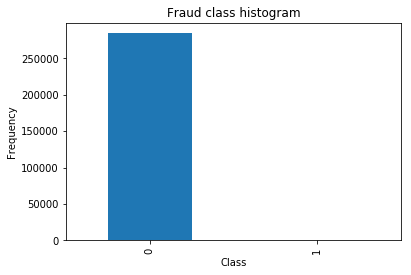

In [11]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [12]:
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [13]:
X = data.drop('Class',axis = 1).values
y = data['Class'].values

target_names = ['Valid Transaction' , 'Fraud Transaction']

In [14]:
print('Shape of Train features is %.f and samples is %.f ' % (X.shape[1],X.shape[0]))
print('Shape of Train labels is %.f' %y.shape[0])

Shape of Train features is 30 and samples is 284807 
Shape of Train labels is 284807


# Applying Techniques

We are going to apply 3 techniques:
   - Random UnderSampling
   - Easy Ensemble
   - SMOTE

## No Method Applied

In [15]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 284315, 1: 492})


First lets work with our Original Data to check the results

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify = y)

print('Training size is %.f'  %y_train.shape[0])
print('Test size is %.f' %y_test.shape[0])

print('Distribution of labels in Train test %s' %Counter(y_train))
print('Distribution of labels in Test set %s' %Counter(y_test))

Training size is 227845
Test size is 56962
Distribution of labels in Train test Counter({0: 227451, 1: 394})
Distribution of labels in Test set Counter({0: 56864, 1: 98})


Lets import and use our classifiers in a naive way

We have to use some metrics such as G-Mean that are not implemented in the sklearn library.  
For that reason, we need to manually make a score function via the make_scorer from sklearn, 
in order to pass it in a dictionary and then cross validate with our algorithm.

- Define Scoring

In [17]:
scoring = {'Accuracy':make_scorer(accuracy_score),
           'Balanced_accuracy':make_scorer(balanced_accuracy_score),'G-Mean':make_scorer(geometric_mean_score),
          'Average Precision-Recall Score':make_scorer(average_precision_score),'ROC Auc Score':make_scorer(roc_auc_score)}



- Define Classifiers

In [18]:
classifiers = {
    "Naive Bayes Classifier": GaussianNB(),
    "RandomForestClassifier": RandomForestClassifier(),
    "Support Vector Classifier": LinearSVC()}


In [0]:
results(classifiers,scoring,X_train,y_train)


Classifier:  Naive Bayes Classifier 

Training score of Accuracy: 0.98 (+/- 0.00)
Training score of Balanced_accuracy: 0.90 (+/- 0.01)
Training score of G-Mean: 0.90 (+/- 0.01)
Training score of Average Precision-Recall Score: 0.05 (+/- 0.00)
Training score of ROC Auc Score: 0.90 (+/- 0.01)

Classifier:  RandomForestClassifier 

Training score of Accuracy: 1.00 (+/- 0.00)
Training score of Balanced_accuracy: 0.98 (+/- 0.01)
Training score of G-Mean: 0.98 (+/- 0.01)
Training score of Average Precision-Recall Score: 0.95 (+/- 0.01)
Training score of ROC Auc Score: 0.98 (+/- 0.01)

Classifier:  Support Vector Classifier 

Training score of Accuracy: 1.00 (+/- 0.00)
Training score of Balanced_accuracy: 0.86 (+/- 0.01)
Training score of G-Mean: 0.85 (+/- 0.01)
Training score of Average Precision-Recall Score: 0.64 (+/- 0.02)
Training score of ROC Auc Score: 0.86 (+/- 0.01)


We clearly have an overfitting case but lets examine it further with a classification report on the test set

In [0]:
clf_imb_report(classifiers,X_train,y_train,X_test,y_test)

Classifiers:  GaussianNB 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.98      1.00      0.06      0.99      0.24      0.06     55550
          1       0.85      0.06      1.00      0.11      0.24      0.05      1412

avg / total       0.97      0.98      0.08      0.97      0.24      0.06     56962

Classifiers:  RandomForestClassifier 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.93      1.00      0.96      0.94     56876
          1       0.82      0.93      1.00      0.87      0.96      0.92        86

avg / total       1.00      1.00      0.93      1.00      0.96      0.94     56962

Classifiers:  LinearSVC 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.85      1.00      0.92      0.86     56870
          1       0.80      0.85      1.00      0.82      0.92      0.8

In [34]:
preds_no_method = {}
for keys, clf in zip(classifiers.keys(),classifiers.values()):
    print("\nEstimator : %s " %keys)
    # Fit in our undersampled train set and predict in our test set
    clf.fit(X_train, y_train)
    preds_no_method[keys] = clf.predict(X_test)



Estimator : Naive Bayes Classifier 

Estimator : RandomForestClassifier 

Estimator : Support Vector Classifier 


E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [35]:
avg_precision_recall_svc = average_precision_score(y_test, preds_no_method["Support Vector Classifier"])
avg_precision_recall_rdf = average_precision_score(y_test, preds_no_method["RandomForestClassifier"])
avg_precision_recall_nb = average_precision_score(y_test, preds_no_method["Naive Bayes Classifier"])

print('SVC Average precision-recall score on test data: {0:0.2f}\n'.format(avg_precision_recall_svc),
      'RDF Average precision-recall score on test data: {0:0.2f}\n'.format(avg_precision_recall_rdf),
      'Naive Bayes Average precision-recall score on test data: {0:0.2f}'.format(avg_precision_recall_nb))

SVC Average precision-recall score on test data: 0.67
 RDF Average precision-recall score on test data: 0.75
 Naive Bayes Average precision-recall score on test data: 0.05


We are going to implement undersample and SMOTE but first we need to cross validate in order to find the best parameters, 
because in other case we would mistakenly be adding bias to our model.

To summarize, when cross-validating with oversampling, we should do the following to make sure 
that the results are generalizable:
- Inside the cross-validation loop, get a sample out and do not use it for anything related to feature selection, 
oversampling or model building.
- Oversample the minority class, without the sample which were already excluded.
- Use the excluded sample for validation, and the oversampled minority class + the majority class, to create the model.
- Repeat n times, where n is the number of samples (if applying leave one participant out cross-validation).


The Wrong Way  
![Wrong Way](./images/wrong.jpg)


---

The Right way  
![Right Way](./images/right.jpg)

## Search for Hyperparameters

For the SVM and Random Forest classifiers we are first going to search in a random area for the best parameters 
and then we will zoom in the area around the best scores and make a grid search.  
We are going to search for C in a logarithmic scale because we are dealing with values from 0.0001 to 1000. 
We want our parameter search to involve a wider range of those values without excluding values near to 0 
as it happens when sampling uniformly.  
For the Naive Bayes Classifier, we are going to search only for the alpha, 
so we are going to skip the random search procedure.  
- Random Search

In [0]:
classifiers = {"RandomForestClassifier": RandomForestClassifier(),
               "Support Vector Classifier": LinearSVC()}

#SVM Hyperparameters search
r = np.random.uniform(-3,3,size = 5)
C = np.array(10**r)
params_svm = {'C' : C}


#Random Forest Classifier
params_rdf = {'max_depth': np.random.randint(4, 30,size = 3),
              'max_features': np.random.randint(1, 9,size = 3),
              'min_samples_split': np.random.randint(2, 11,size = 3)}

params = [params_rdf,params_svm]
#Results
res = {}

for keys, classifier ,params in zip(classifiers.keys(),classifiers.values(),params):
    res[keys] = hyperparameters(classifier,params,X_train,y_train,scoring,keys,random_search=True)




Εstimator : RandomForestClassifier
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.8min finished


Best parameters found for Estimator : RandomForestClassifier
{'min_samples_split': 4, 'max_features': 6, 'max_depth': 18}

Best score found for G-Mean Score metric : 0.874

Εstimator : Support Vector Classifier
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished


Best parameters found for Estimator : Support Vector Classifier
{'C': 231.76480333117937}

Best score found for G-Mean Score metric : 0.891


Now that we found our best parameters it is time to make a grid search in a specific area  
- Grid Search

In [0]:
classifiers = {"RandomForestClassifier": RandomForestClassifier(),
               "Support Vector Classifier": LinearSVC(),
               "Naive Bayes Classifier": GaussianNB()}


#Parameters Random Forest Classifier
params_rdf = {'max_depth': [17,19,18],
              'max_features': [5,6,7],
              'min_samples_split': [3,4,5,6]}    

#Parameters Support Vector Classifier
params_svc = {'C' : [231.5,232,234,230]}

#Naive Bayes Classifier
param_nb = {"var_smoothing": np.arange(0, 10, 0.2)}


params = [params_rdf , params_svc ,param_nb]

for keys, classifier ,params in zip(classifiers.keys(),classifiers.values(),params):
    res[keys] = hyperparameters(classifier,params,X_train,y_train,scoring,keys,random_search=False)
    


Εstimator : RandomForestClassifier
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 10.0min finished


Best parameters found for Estimator : RandomForestClassifier
{'max_depth': 19, 'max_features': 5, 'min_samples_split': 5}

Best score found for G-Mean Score metric : 0.885

Εstimator : Support Vector Classifier
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.8min finished


Best parameters found for Estimator : Support Vector Classifier
{'C': 231.5}

Best score found for G-Mean Score metric : 0.889

Εstimator : Naive Bayes Classifier
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


Best parameters found for Estimator : Naive Bayes Classifier
{'var_smoothing': 0.0}

Best score found for G-Mean Score metric : 0.898


We found the optimal parameters for our classifiers so we will proceed in the next steps; 
undersampling and cross validating in our new set

In [0]:
classifiers = {"RandomForestClassifier": RandomForestClassifier(max_depth=19, max_features=5,min_samples_split=5),
               "Support Vector Classifier": LinearSVC(C= 231.76480333117937),
               "Naive Bayes Classifier": GaussianNB(var_smoothing=0.0)}

## Undersampling

Lets proceed to the Undersampling technique

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 394, 1: 394})
Distribution of the Classes in the subsample dataset


Text(0,0.5,'Frequency')

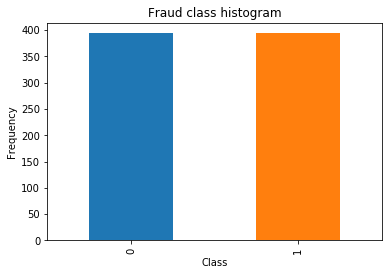

In [0]:
print('Original dataset shape %s' % Counter(y))

rund = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = rund.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_undersampled))


print('Distribution of the Classes in the subsample dataset')
count_classes = pd.value_counts(y_undersampled, sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

### Validation on resampled set

In [0]:
preds = {}
for keys, clf in zip(classifiers.keys(),classifiers.values()):
    print("\nEstimator : %s " %keys)
    # Fit in our undersampled train set and predict in our test set
    preds[keys] = cross_val_predict(clf,X_undersampled,y_undersampled,cv = 4)
    print(classification_report_imbalanced(preds[keys],y_undersampled))



Estimator : RandomForestClassifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.92      0.96      0.94      0.94      0.88       415
          1       0.91      0.96      0.92      0.94      0.94      0.89       373

avg / total       0.94      0.94      0.94      0.94      0.94      0.88       788


Estimator : Support Vector Classifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.94      0.95      0.94      0.94      0.89       402
          1       0.93      0.95      0.94      0.94      0.94      0.89       386

avg / total       0.94      0.94      0.94      0.94      0.94      0.89       788


Estimator : Naive Bayes Classifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.88      0.97      0.92      0.92      0.84       434
          1       0.87      0.97      0.88      0

In [0]:
from sklearn.metrics import roc_auc_score 


print('Gaussian NB Classifier: {:.4f} '.format(roc_auc_score(y_undersampled, preds["Naive Bayes Classifier"])))
print('Support Vector Classifier: {:.4f}'.format(roc_auc_score(y_undersampled, preds["Support Vector Classifier"])))
print('Random Forest Classifier: {:.4f}'.format(roc_auc_score(y_undersampled, preds["RandomForestClassifier"])))

names = ["Gaussian NB Classifier","Support Vector Classifier","Random Forest Classifier"]

Gaussian NB Classifier: 0.9188 
Support Vector Classifier: 0.9442
Random Forest Classifier: 0.9378


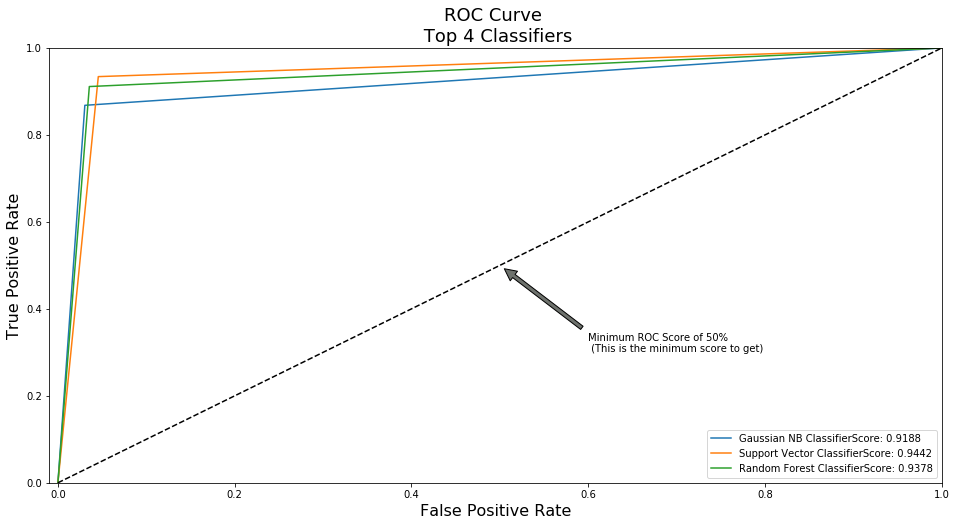

In [0]:
gnb_fpr, gnb_tpr, gnb_threshold = roc_curve(y_undersampled, preds["Naive Bayes Classifier"])
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_undersampled, preds["Support Vector Classifier"])
rdf_fpr, rdf_tpr, rdf_threshold = roc_curve(y_undersampled, preds["RandomForestClassifier"])

graph_roc_curve_multiple(gnb_fpr,gnb_tpr,roc_auc_score(y_undersampled, preds["Naive Bayes Classifier"]),
                           svc_fpr,svc_tpr,roc_auc_score(y_undersampled, preds["Support Vector Classifier"]),
                           rdf_fpr,rdf_tpr,roc_auc_score(y_undersampled, preds["RandomForestClassifier"]),
                                                        names)

Roc Curve for Support Vector Classifier

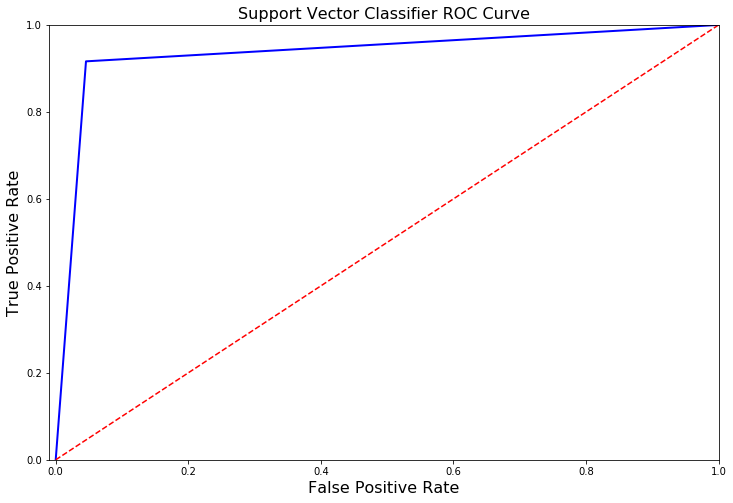

In [0]:
roc_curve_(svc_fpr, svc_tpr, "Support Vector Classifier ")

We are going to implement 5 fold Stratified Shuffle Split Validation as follows:
- Split our Train Test in 5 folds of which 90% of the data will be for training and 10% for validation.
- Leave the 10% of our validation out and resample only the training set.
- Cross validate on the validation set.


### Cross validation on the original set 

In [0]:
sampler = RandomUnderSampler(random_state=42)

for keys, clf in zip(classifiers.keys(),classifiers.values()):
    print("\nClassifier : " +keys, "\n")
    tic = time.time()
    res = resample_cross_val(clf,X_train,y_train,sampler,cv = 5)
    toc = time.time() - tic
    for key , values in zip(res.keys(),res.values()):
        print(key,values)
    print("\nTime needed to execute for 5 validation folds = %.3f " %toc)


Classifier : RandomForestClassifier 

Accuracy Score =  0.964
Accuracy Std =  0.009
Balanced Accuracy Score =  0.522
Balanced Accuracy Std =  0.006
Average Precision Recall Score =  0.075
Average Precision Recall Std =  0.005
Roc Auc Score =  0.522
Roc Auc Std =  0.006
G Mean Score =  0.208
G Mean Std =  0.026

Time needed to execute for 5 validation folds = 1.004 

Classifier : Support Vector Classifier 

Accuracy Score =  0.925
Accuracy Std =  0.026
Balanced Accuracy Score =  0.511
Balanced Accuracy Std =  0.003
Average Precision Recall Score =  0.096
Average Precision Recall Std =  0.02
Roc Auc Score =  0.511
Roc Auc Std =  0.003
G Mean Score =  0.148
G Mean Std =  0.022

Time needed to execute for 5 validation folds = 1.118 

Classifier : Naive Bayes Classifier 

Accuracy Score =  0.966
Accuracy Std =  0.006
Balanced Accuracy Score =  0.521
Balanced Accuracy Std =  0.003
Average Precision Recall Score =  0.07
Average Precision Recall Std =  0.002
Roc Auc Score =  0.521
Roc Auc Std

It seems like the Random Forest Classifier got the best results in our validation set but lets have another evaluation.
Clearly an overfitted case but lets examine the Roc Auc Scores and plots.
Lets choose the Support Vector Classifier as we see it gets the best results.

### Predictions on Test set

In [0]:
preds = {}
for keys, clf in zip(classifiers.keys(),classifiers.values()):
    print("\nEstimator : %s " %keys)
    # Fit in our undersampled train set and predict in our test set
    clf.fit(X_undersampled, y_undersampled)
    preds[keys] = clf.predict(X_test)
    print(classification_report_imbalanced(preds[keys],y_test))



Estimator : RandomForestClassifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      0.03      0.97      0.18      0.03     54069
          1       0.91      0.03      1.00      0.06      0.18      0.03      2893

avg / total       0.95      0.95      0.08      0.93      0.18      0.03     56962


Estimator : Support Vector Classifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      1.00      0.01      0.93      0.11      0.01     49306
          1       0.93      0.01      1.00      0.02      0.11      0.01      7656

avg / total       0.88      0.87      0.14      0.81      0.11      0.01     56962


Estimator : Naive Bayes Classifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      1.00      0.04      0.98      0.19      0.04     54659
          1       0.88      0.04      1.00      0

We are going to select our best classifier which was the Naive bayes as we saw from the results

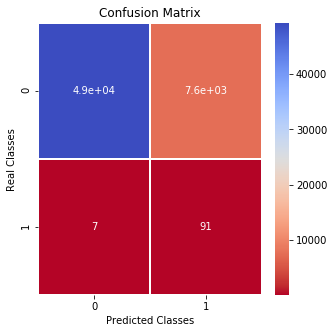

In [0]:
plot_confusion_matrix(y_test,preds["Naive Bayes Classifier"])

As we see we get very poor results with our test set

In [0]:
avg_precision_recall_svc = average_precision_score(y_test, preds["Support Vector Classifier"])
avg_precision_recall_rdf = average_precision_score(y_test, preds["RandomForestClassifier"])
avg_precision_recall_nb = average_precision_score(y_test, preds["Naive Bayes Classifier"])


print('SVC Average precision-recall score on test data: {0:0.2f}\n'.format(avg_precision_recall_svc),
      'RDF Average precision-recall score on test data: {0:0.2f}\n'.format(avg_precision_recall_rdf),
      'Naive Bayes Average precision-recall score on test data: {0:0.2f}'.format(avg_precision_recall_nb))


SVC Average precision-recall score on test data: 0.03
 RDF Average precision-recall score on test data: 0.03
 Naive Bayes Average precision-recall score on test data: 0.03


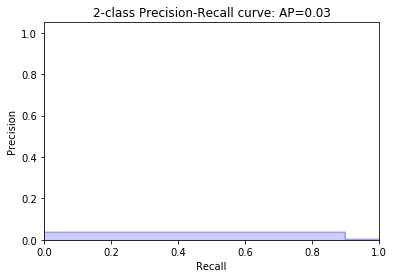

In [0]:
precision, recall, _ = precision_recall_curve(y_test, preds["Naive Bayes Classifier"])

prec_rec_curve(precision,recall,avg_precision_recall_rdf)

## SMOTE

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 227451, 1: 227451})
Distribution of the Classes in the subsample dataset


Text(0,0.5,'Frequency')

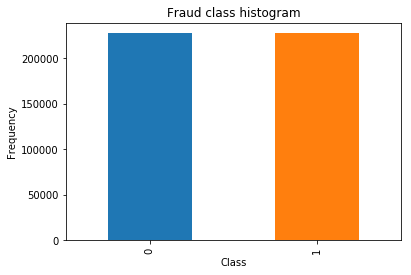

In [19]:
print('Original dataset shape %s' % Counter(y))

sampler = SMOTE(random_state=42)
X_oversampled, y_oversampled = sampler.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_oversampled))


print('Distribution of the Classes in the subsample dataset')
count_classes = pd.value_counts(y_oversampled, sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

We already know the best parameters for our models so we will skip that step and proceed with oversampling and fitting.

### Validation on resampled set

In [20]:
preds_oversampled = {}
for keys, clf in zip(classifiers.keys(),classifiers.values()):
    print("\nEstimator : %s " %keys)
    
    #Cross validation predicts in order to create our roc auc score for our oversampled data
    preds_oversampled[keys] = cross_val_predict(clf,X_oversampled,y_oversampled,cv=5)
    print(classification_report_imbalanced(preds_oversampled[keys],y_oversampled))




Estimator : Naive Bayes Classifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.86      0.97      0.92      0.92      0.83    256442
          1       0.85      0.97      0.86      0.91      0.92      0.85    198460

avg / total       0.92      0.91      0.93      0.91      0.92      0.84    454902


Estimator : RandomForestClassifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    227411
          1       1.00      1.00      1.00      1.00      1.00      1.00    227491

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    454902


Estimator : Support Vector Classifier 


E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.93      0.97      0.95      0.95      0.90    239151
          1       0.92      0.97      0.93      0.95      0.95      0.91    215751

avg / total       0.95      0.95      0.95      0.95      0.95      0.90    454902



In [0]:
from sklearn.metrics import roc_auc_score 

print('Gaussian NB Classifier: {:.4f} '.format(roc_auc_score(y_oversampled, preds_oversampled["Naive Bayes Classifier"])))
print('Support Vector Classifier: {:.4f}'.format(roc_auc_score(y_oversampled, preds_oversampled["Support Vector Classifier"])))
print('Random Forest Classifier: {:.4f}'.format(roc_auc_score(y_oversampled, preds_oversampled["RandomForestClassifier"])))

names = ["Gaussian NB Classifier","Support Vector Classifier","Random Forest Classifier"]

Gaussian NB Classifier: 0.9114 
Support Vector Classifier: 0.9282
Random Forest Classifier: 0.9997


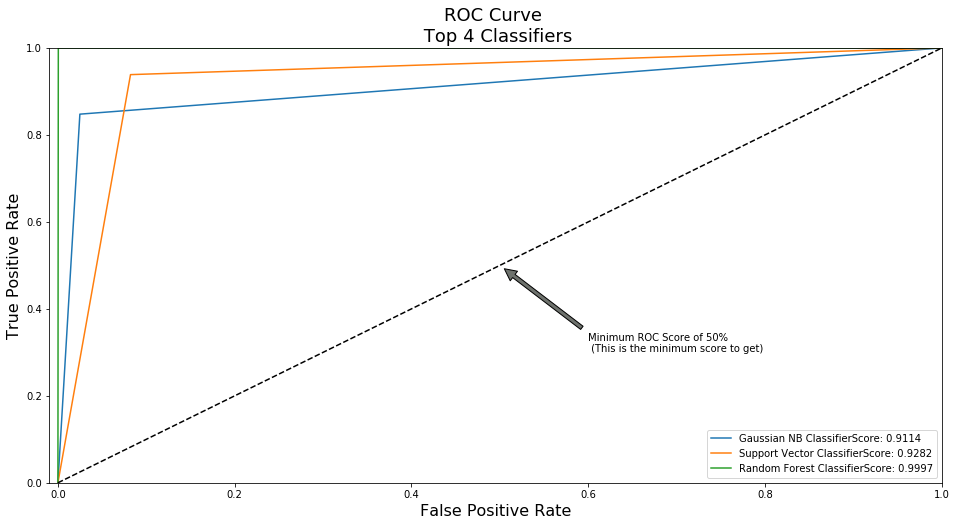

In [0]:
gnb_fpr, gnb_tpr, gnb_threshold = roc_curve(y_oversampled, preds_oversampled["Naive Bayes Classifier"])
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_oversampled, preds_oversampled["Support Vector Classifier"])
rdf_fpr, rdf_tpr, rdf_threshold = roc_curve(y_oversampled, preds_oversampled["RandomForestClassifier"])

graph_roc_curve_multiple(gnb_fpr,gnb_tpr,roc_auc_score(y_oversampled, preds_oversampled["Naive Bayes Classifier"]),
                           svc_fpr,svc_tpr,roc_auc_score(y_oversampled, preds_oversampled["Support Vector Classifier"]),
                           rdf_fpr,rdf_tpr,roc_auc_score(y_oversampled, preds_oversampled["RandomForestClassifier"]),
                                                        names)

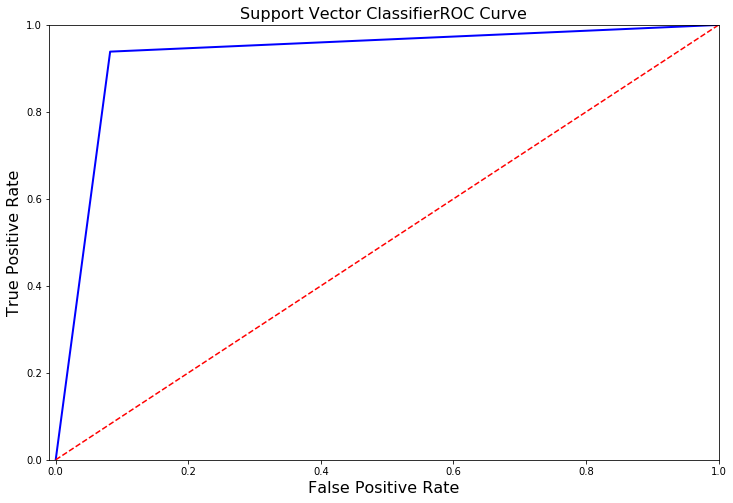

In [0]:
roc_curve_(svc_fpr, svc_tpr, "Support Vector Classifier")

### Cross validation in our original set

In [0]:
sampler = SMOTE(random_state=42)
for keys, clf in zip(classifiers.keys(),classifiers.values()):
    print("\nClassifier : " +keys, "\n")
    tic = time.time()
    res = resample_cross_val(clf,X_train,y_train,sampler,cv = 5)
    toc = time.time() - tic
    for key , values in zip(res.keys(),res.values()):
        print(key,values)
    print("Time needed to execute for 5 validation folds = %.2f minutes" %(toc/60))


Classifier : RandomForestClassifier 

Accuracy Score =  0.999
Accuracy Std =  0.0
Balanced Accuracy Score =  0.857
Balanced Accuracy Std =  0.015
Average Precision Recall Score =  0.535
Average Precision Recall Std =  0.041
Roc Auc Score =  0.857
Roc Auc Std =  0.015
G Mean Score =  0.845
G Mean Std =  0.018
Time needed to execute for 5 validation folds = 126.455 

Classifier : Support Vector Classifier 

Accuracy Score =  0.918
Accuracy Std =  0.046
Balanced Accuracy Score =  0.512
Balanced Accuracy Std =  0.006
Average Precision Recall Score =  0.103
Average Precision Recall Std =  0.037
Roc Auc Score =  0.512
Roc Auc Std =  0.006
G Mean Score =  0.15
G Mean Std =  0.038
Time needed to execute for 5 validation folds = 469.752 

Classifier : Naive Bayes Classifier 

Accuracy Score =  0.975
Accuracy Std =  0.001
Balanced Accuracy Score =  0.527
Balanced Accuracy Std =  0.002
Average Precision Recall Score =  0.071
Average Precision Recall Std =  0.004
Roc Auc Score =  0.527
Roc Auc St

### Predictions on Test set

In [21]:
preds_test_oversampled = {}
for keys, clf in zip(classifiers.keys(),classifiers.values()):
    print("\nEstimator : %s " %keys)
    # Fit in our undersampled train set and predict in our test set
    clf.fit(X_oversampled, y_oversampled)
    preds_test_oversampled[keys] = clf.predict(X_test)
    print(classification_report_imbalanced(preds_test_oversampled[keys],y_test))


Estimator : Naive Bayes Classifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      1.00      0.05      0.99      0.23      0.06     55357
          1       0.88      0.05      1.00      0.10      0.23      0.05      1605

avg / total       0.97      0.97      0.08      0.96      0.23      0.06     56962


Estimator : RandomForestClassifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.88      1.00      0.94      0.89     56870
          1       0.83      0.88      1.00      0.85      0.94      0.87        92

avg / total       1.00      1.00      0.88      1.00      0.94      0.89     56962


Estimator : Support Vector Classifier 
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      1.00      0.06      0.99      0.24      0.07     55455
          1       0.92      0.06      1.00      0

E:\Anaconda3\envs\Ai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


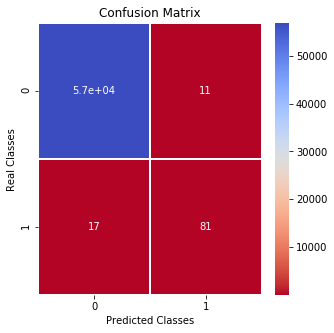

In [25]:
plot_confusion_matrix(y_test,preds_test_oversampled["RandomForestClassifier"])

In [22]:
avg_precision_recall_svc = average_precision_score(y_test, preds_test_oversampled["Support Vector Classifier"])
avg_precision_recall_rdf = average_precision_score(y_test, preds_test_oversampled["RandomForestClassifier"])
avg_precision_recall_nb = average_precision_score(y_test, preds_test_oversampled["Naive Bayes Classifier"])

print('SVC Average precision-recall score on test data: {0:0.2f}\n'.format(avg_precision_recall_svc),
      'RDF Average precision-recall score on test data: {0:0.2f}\n'.format(avg_precision_recall_rdf),
      'Naive Bayes Average precision-recall score on test data: {0:0.2f}'.format(avg_precision_recall_nb))

SVC Average precision-recall score on test data: 0.05
 RDF Average precision-recall score on test data: 0.73
 Naive Bayes Average precision-recall score on test data: 0.05


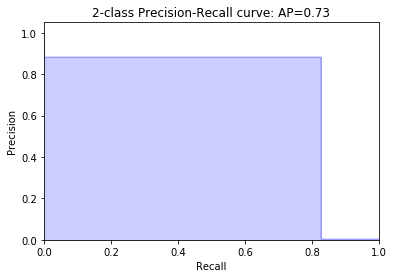

In [24]:
precision, recall, _ = precision_recall_curve(y_test, preds_test_oversampled["RandomForestClassifier"])

prec_rec_curve(precision,recall,avg_precision_recall_rdf)

## Easy Ensemble

Create an ensemble set by iteratively applying random under-sampling.

We will make 5 shuffled splits in order to be able to cross validate in them.

In [26]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.10, random_state=0)
X_vals = {}
y_vals = {}
i = 0
for train_index, val_index  in sss.split(X_train, y_train):
    print("VAL:", val_index)
    _, X_val = X[train_index], X[val_index]
    _, y_val = y[train_index], y[val_index]
    X_vals["Val" + str(i)] = X_val
    y_vals["Val" + str(i)] = y_val
    i+=1
    print("Validation set {} size:".format(str(i)), X_val.shape[0])

VAL: [141087 202236 118407 ...  62015  92555 127800]
Validation set 1 size: 22785
VAL: [ 27321 222474 224195 ... 205613  75105 178860]
Validation set 2 size: 22785
VAL: [ 42883 136653 218869 ... 117619  66209 174106]
Validation set 3 size: 22785
VAL: [111481   2305 167212 ... 157089 223571  32458]
Validation set 4 size: 22785
VAL: [143423 145815 188420 ...  23538 222658 151915]
Validation set 5 size: 22785


Original dataset shape Counter({0: 227451, 1: 394})
Number of resampled datasets: 11
Resampled dataset ensmebles shape is Counter({0: 394, 1: 394})
Distribution of the Classes in the subsample dataset


Text(0,0.5,'Frequency')

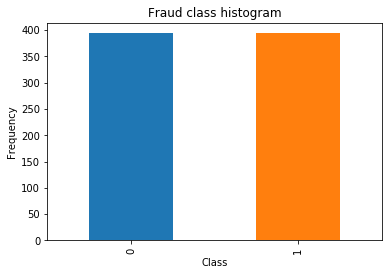

In [27]:
print('Original dataset shape %s' % Counter(y_train))

#Create 11 ensemble resampled sets (We will keep the 11th for validation)


sampler = EasyEnsemble(random_state=10,replacement=False , n_subsets=11)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

print('Number of resampled datasets: 11')
print('Resampled dataset ensembles shape is %s' % Counter(y_resampled[0]))


print('Distribution of the Classes in the subsample dataset')
count_classes = pd.value_counts(y_resampled[0], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

- Random Search 

### Hyperparameters search for XGB Classifier

In [28]:
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

params = {'min_child_weight': sp_randint(4, 30),
        'gamma': np.random.uniform(0.5,4,size = 5),
        'subsample': np.random.uniform(0,1,size =4),
        'colsample_bytree': np.random.uniform(0,1,size =4),
        'max_depth': sp_randint(1, 7)}

res = hyperparameters(xgb_clf,params,X_train,y_train,scoring,"XGB Classifier",random_search=True)




Εstimator : XGB Classifier
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 11.7min finished


Best parameters found for Estimator : XGB Classifier
{'colsample_bytree': 0.7797706012939293, 'gamma': 1.5838134488118056, 'max_depth': 2, 'min_child_weight': 12, 'subsample': 0.9444717875545451}

Best score found for G-Mean Score metric : 0.878


- Grid Search

In [0]:
params = {'min_child_weight': [8,9,10],
        'max_depth': [4,5,6],
         'colsample_bytree':[0.4154703562955012] ,'gamma':[1.2526844434195878],'subsample':[0.7788902025017921]}


res_grid = hyperparameters(xgb_clf,params,X_train,y_train,scoring,"XGB Classifier",random_search=False)



Εstimator : XGB Classifier
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 24.2min finished


Best parameters found for Estimator : XGB Classifier
{'colsample_bytree': 0.4154703562955012, 'gamma': 1.2526844434195878, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7788902025017921}

Best score found for G-Mean Score metric : 0.879


### Define our 10 Boosting Classifiers

In [65]:
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1,colsample_bytree = 0.4154703562955012,gamma = 1.2526844434195878,
                    subsample = 0.7788902025017921,min_child_weight = 10,max_depth =4 )

In [66]:
estimators = {"XGB"+ str(l+1):xgb_clf for l in range(10)} 
X_sets = [X_resampled[i][:] for i in range(10)]
y_sets = [y_resampled[i][:] for i in range(10)]

### Validation on the 11'th resampled set we created

In [0]:
for clf,X,y,names in zip(estimators.values(),X_sets,y_sets,estimators.keys()):
    scores = cross_val_score(clf, X, y, cv=5,scoring="balanced_accuracy")
    print("%s Balanced Accuracy Score : %0.2f (+/- %0.2f) "
          % (names, scores.mean(), scores.std()))

XGB1 Balanced Accuracy Score : 0.94 (+/- 0.02) 
XGB2 Balanced Accuracy Score : 0.94 (+/- 0.01) 
XGB3 Balanced Accuracy Score : 0.94 (+/- 0.02) 
XGB4 Balanced Accuracy Score : 0.93 (+/- 0.02) 
XGB5 Balanced Accuracy Score : 0.94 (+/- 0.02) 
XGB6 Balanced Accuracy Score : 0.95 (+/- 0.02) 
XGB7 Balanced Accuracy Score : 0.94 (+/- 0.01) 
XGB8 Balanced Accuracy Score : 0.95 (+/- 0.02) 
XGB9 Balanced Accuracy Score : 0.93 (+/- 0.02) 
XGB10 Balanced Accuracy Score : 0.94 (+/- 0.02) 


**!Note: Because Scikit Learn does not support voting classifier for fitted classifiers 
we are going to implement an ensemble estimator for fitted classifiers.(See in utils package)**

In [67]:
eclf = VotingClassifier(estimators.values(),weights = None)
eclf.fit(X_sets,y_sets)

Lets first evaluate it in an undersampled set we got from EasyEnsemble

In [0]:
print("\nClassifier : EasyEnsemble Voting Classifier", "\n")
tic = time.time()
preds = eclf.predict(X_resampled[10][:])
toc = time.time() - tic

print(classification_report_imbalanced(preds,y_resampled[10][:],target_names = target_names))


Classifier : EasyEnsemble Voting Classifier 

                         pre       rec       spe        f1       geo       iba       sup

Valid Transaction       0.97      0.95      0.97      0.96      0.96      0.92       402
Fraud Transaction       0.95      0.97      0.95      0.96      0.96      0.92       386

      avg / total       0.96      0.96      0.96      0.96      0.96      0.92       788



In [0]:
print('XGBoost Ensemble Classifier Roc Auc Score : {:.4f}'.format(roc_auc_score(y_resampled[10],preds)))



XGBoost Ensemble Classifier Roc Auc Score : 0.9594


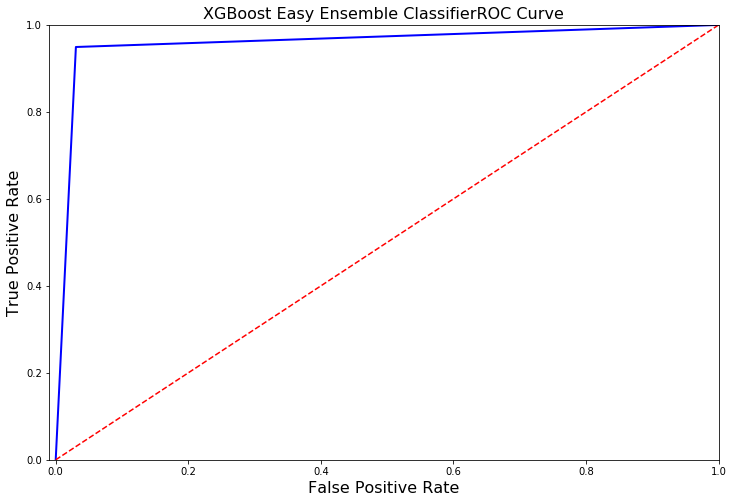

In [0]:
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_resampled[10], preds)
roc_curve_(xgb_fpr, xgb_tpr, "XGBoost Easy Ensemble Classifier")

### Validate on stratified shuffled sets we kept before resampling

In [98]:
res = validate_easy_ensemble(eclf,X_vals,y_vals)
for key , values in zip(res.keys(),res.values()):
    print(key,values)

Accuracy Score =  0.967
Accuracy Std =  0.001
Balanced Accuracy Score =  0.524
Balanced Accuracy Std =  0.003
Average Precision Recall Score =  0.08
Average Precision Recall Std =  0.004
Roc Auc Score =  0.524
Roc Auc Std =  0.003
G Mean Score =  0.22
G Mean Std =  0.013


### Finally lets predict our original Test set

In [0]:
preds = eclf.predict(X_test)
print(classification_report_imbalanced(preds,y_test,target_names = target_names))

                         pre       rec       spe        f1       geo       iba       sup

Valid Transaction       0.96      1.00      0.04      0.98      0.21      0.05     54866
Fraud Transaction       0.92      0.04      1.00      0.08      0.21      0.04      2096

      avg / total       0.96      0.96      0.08      0.95      0.21      0.05     56962



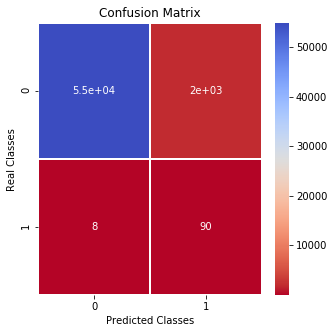

In [0]:
plot_confusion_matrix(y_test,preds)

In [0]:
avg_precision_recall = average_precision_score(y_test,preds)
print('Average precision-recall score on test data: {0:0.2f}'.format(
      avg_precision_recall))

Average precision-recall score on test data: 0.04


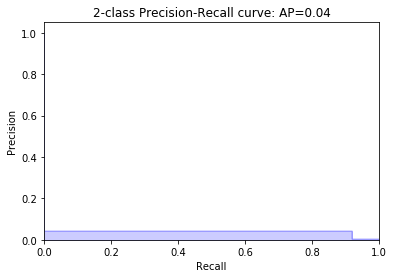

In [0]:
precision, recall, _ = precision_recall_curve(y_test, preds)

prec_rec_curve(precision,recall,avg_precision_recall)

# Conclusions
The results of all the methods applied are presented in the following table:  
![Results](./images/PartC_Results.png)  
As we can see, SMOTE performs better than both EasyEnsemble and RandomUndersampling in this case. 
Our original set is highly unbalanced and even a very good method like EasyEnsemble can't have the outcomes we seek. 
Therefore it is recommended for this case to use SMOTE in order to have the best results.